In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
from io import StringIO
import datetime as dt

# Carga de datos

In [2]:
# URL base de la API
base_url_ws_col = "https://www.datos.gov.co/resource/57ur-5p28.csv"

# Parámetros
limit = 1000  # número máximo permitido por la API
offset = 0    # desplazamiento inicial
all_data = [] # lista para almacenar los bloques

csv_file_ws_col = "../data/raw/datos_bmanga.csv"

In [3]:
if os.path.exists(csv_file_ws_col):
    ws_col = pd.read_csv(csv_file_ws_col)
    print("Se carga el archivo csv")
else:
    while True:
        # Construir URL con paginación
        url = f"{base_url_ws_col}?$limit={limit}&$offset={offset}"
        print(f"Descargando: {url}")

        # Hacer la solicitud
        response = requests.get(url)
        
        # Si falla la solicitud, salir
        if response.status_code != 200:
            print(f"Error en la descarga: {response.status_code}")
            break

        # Leer el bloque como DataFrame
        df_chunk = pd.read_csv(StringIO(response.text))
        
        # Si el bloque está vacío, terminamos
        if df_chunk.empty:
            break
        
        # Agregar a la lista
        all_data.append(df_chunk)
        
        # Aumentar el offset para el siguiente bloque
        offset += limit
    # Unir todos los bloques en un solo DataFrame
    ws_col = pd.concat(all_data, ignore_index=True)

    print(f"Total de registros descargados: {len(ws_col)}")

    ws_col.to_csv(csv_file_ws_col, index=False)

Se carga el archivo csv


# Preprocesamiento

In [4]:
# Copia del df original
df_col = ws_col.copy()

In [5]:

df_col.head()

,estaci_n,tipo,coordenada_x,coordenada_y,date,time,out,hum,speed,dir,bar,rain,rad,index
0,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T00:00:00.000,22.1,98.0,0.0,SE,676.0,0.0,0.0,-999.0
1,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T01:00:00.000,20.3,96.0,0.4,SE,676.2,5.2,0.0,-999.0
2,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T02:00:00.000,20.1,99.0,0.4,WSW,675.8,25.6,0.0,-999.0
3,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T03:00:00.000,19.6,99.0,0.4,SSE,675.6,6.0,0.0,-999.0
4,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01T00:00:00.000,1899-12-31T04:00:00.000,19.8,99.0,0.0,SSE,675.9,0.2,0.0,-999.0


En la columna `dir` se cambia los valores cardinales a grados.

In [6]:
cardinal_to_deg = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

In [7]:
# Normalizar a string para detectar cardinales
df_col['dir'] = df_col['dir'].astype(str).str.strip().str.upper()

# Convertir cardinales a grados
df_col['dir_deg'] = df_col['dir'].map(cardinal_to_deg)

# Si no es cardinal, intentar convertir a número
df_col['dir_deg'] = df_col['dir_deg'].fillna(pd.to_numeric(df_col['dir'], errors='coerce'))

# Reemplazar valores inválidos
df_col['dir_deg'] = df_col['dir_deg'].replace([-999, -999.0], np.nan)

# Si hay valores > 360, llevarlos al rango [0,360)
df_col['dir_deg'] = df_col['dir_deg'] % 360

Se arregla la columna `bar` que indica la presión registrada.

In [8]:
# Reemplazar valores inválidos
df_col['bar'] = df_col['bar'].replace([-999, -999.0], np.nan)

Se arregla la columna `speed` que indica la velocidad del viento registrada.

In [9]:
(df_col["speed"].value_counts() / df_col.shape[0]).apply(lambda a: f"{100 * a:.2f} %")

speed
 0.000      32.23 %
-999.000    17.57 %
 0.400      11.99 %
 0.900       6.94 %
 1.300       4.53 %
             ...   
 2.425       0.00 %
 2.009       0.00 %
 1.736       0.00 %
 3.304       0.00 %
 1.786       0.00 %
Name: count, Length: 874, dtype: object

In [10]:
# # Reemplazar valores inválidos
# df_col['speed'] = df_col['speed'].replace([-999, -999.0], np.nan)

Se toma las columnas `date` y `time` para ser combinadas y obtener la columnas `datetime`.

In [11]:
# Supongamos que df_col tiene las columnas 'date' y 'time'
df_col['date'] = pd.to_datetime(df_col['date'])
df_col['time'] = pd.to_datetime(df_col['time']).dt.time  # extraer solo la hora

# Combinar
df_col['datetime'] = df_col.apply(lambda row: pd.Timestamp.combine(row['date'], row['time']), axis=1)

Se elimnan los valores `nan` del dataframe

In [12]:
df_col.shape

(138566, 16)

In [13]:
df_col = df_col.loc[
    ~ df_col["dir_deg"].isna() &
    ~ df_col["bar"].isna()
].copy()

df_col.shape

(77664, 16)

In [14]:
f"Se conserva un total de {100 * df_col.shape[0] / ws_col.shape[0]:.2f}% de los datos originales"

'Se conserva un total de 56.05% de los datos originales'

In [15]:
df_col.head()

,estaci_n,tipo,coordenada_x,coordenada_y,date,time,out,hum,speed,dir,bar,rain,rad,index,dir_deg,datetime
0,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,00:00:00,22.1,98.0,0.0,SE,676.0,0.0,0.0,-999.0,135.0,2021-06-01 00:00:00
1,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,01:00:00,20.3,96.0,0.4,SE,676.2,5.2,0.0,-999.0,135.0,2021-06-01 01:00:00
2,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,02:00:00,20.1,99.0,0.4,WSW,675.8,25.6,0.0,-999.0,247.5,2021-06-01 02:00:00
3,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,03:00:00,19.6,99.0,0.4,SSE,675.6,6.0,0.0,-999.0,157.5,2021-06-01 03:00:00
4,ACAPULCO,CLIMATOLOGICA,1102787,1265648,2021-06-01,04:00:00,19.8,99.0,0.0,SSE,675.9,0.2,0.0,-999.0,157.5,2021-06-01 04:00:00


In [16]:
fechas , conteo = np.unique(df_col["datetime"], return_counts=True)

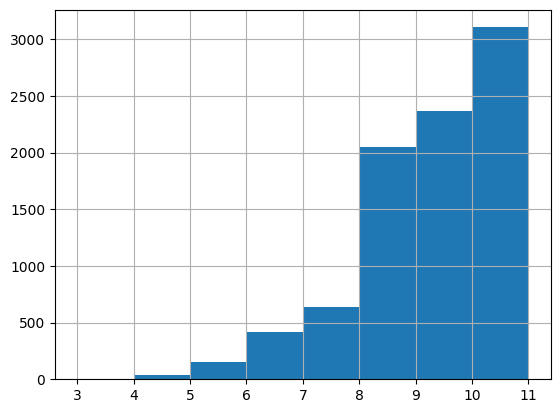

In [17]:
plt.hist(conteo, bins=len(np.unique(conteo))- 1)
plt.grid()
plt.show()

Se necesita que las estaciones tengas la misma cantidad y los mismo registros de fecha

In [18]:
top_fechas = fechas[np.where(conteo >= 9)]

In [19]:
df_cln = df_col[df_col["datetime"].isin(top_fechas)].copy()

In [20]:
df_col.shape , df_cln.shape

((77664, 16), (53425, 16))

In [21]:
df_cln = df_cln.sort_values("datetime").reset_index(drop=True)

In [22]:
df_cln["datetime"].diff().value_counts().head()

datetime
0 days 00:00:00    47955
0 days 01:00:00     5306
0 days 02:00:00       41
0 days 17:00:00       17
0 days 16:00:00       16
Name: count, dtype: int64

In [23]:
# Se identifican los registros que se encuentran seguidos
grupos_fechas = dict()
count = 1
for idx in range(df_cln.shape[0] - 1):
    if not f"grupo_{count}" in grupos_fechas: grupos_fechas[f"grupo_{count}"] = list()
    delta_tiempo = df_cln.loc[[idx, idx + 1], "datetime"].diff()[idx + 1]
    if delta_tiempo in [dt.timedelta(hours=0), dt.timedelta(hours=1)]: grupos_fechas[f"grupo_{count}"].append(idx + 1)
    else:
        count += 1
        grupos_fechas[f"grupo_{count}"] = [idx + 1]

In [24]:
print(f"Se obtienen {len(grupos_fechas)} grupos.")
grupos_fechas_largo = {k: len(l) for k, l in grupos_fechas.items()}
grupo_mas_largo = max(grupos_fechas_largo.values())
for k, l in grupos_fechas_largo.items():
    if l == grupo_mas_largo:
        print(f"El grupo más largo es el grupo {k} con {grupo_mas_largo:,} registros.")

Se obtienen 164 grupos.
El grupo más largo es el grupo grupo_67 con 8,086 registros.


In [25]:
print(f"""
min: {df_cln.loc[grupos_fechas["grupo_67"], "datetime"].unique().min()}
max: {df_cln.loc[grupos_fechas["grupo_67"], "datetime"].unique().max()}
unq: {len(df_cln.loc[grupos_fechas["grupo_67"], "datetime"].unique())}
      """)


min: 2021-06-30 12:00:00
max: 2021-07-31 23:00:00
unq: 756
      


## Grupo 67

In [26]:
g67 = df_cln.loc[grupos_fechas["grupo_67"]].copy()

In [27]:
g67.shape

(8086, 16)

In [28]:
g67["estaci_n"].value_counts()

estaci_n
BETANIA         756
EL ROBLE        756
EL RASGÓN       756
LA AGUADA       756
EL DIAMANTE     756
LA NARANJERA    756
LAGO ALTO       756
LA JUDIA        735
TURBAY          735
ACAPULCO        695
PORTUGAL        629
Name: count, dtype: int64

In [29]:
estaciones_ok_g67 = list()
for estacion in g67["estaci_n"].unique():
    info = g67.loc[g67["estaci_n"] == estacion, "datetime"].diff().unique()
    # print(f"{info}")
    if len(info) == 2 and estacion != "ACAPULCO":
        print(estacion)
        estaciones_ok_g67.append(estacion)

BETANIA
EL ROBLE
EL RASGÓN
EL DIAMANTE
LA NARANJERA
LAGO ALTO
LA AGUADA


In [30]:
for estacion in estaciones_ok_g67:
    fecha_min = g67.loc[g67["estaci_n"] == estacion, "datetime"].min()
    fecha_max = g67.loc[g67["estaci_n"] == estacion, "datetime"].max()
    print(f"""
estacion:   {estacion}
fecha min:  {fecha_min}
fecha max:  {fecha_max}
          """)


estacion:   BETANIA
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          

estacion:   EL ROBLE
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          

estacion:   EL RASGÓN
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          

estacion:   EL DIAMANTE
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          

estacion:   LA NARANJERA
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          

estacion:   LAGO ALTO
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          

estacion:   LA AGUADA
fecha min:  2021-06-30 12:00:00
fecha max:  2021-07-31 23:00:00
          


In [31]:
g67 = g67[g67["estaci_n"].isin(estaciones_ok_g67)].copy()
g67["datetime"].value_counts().sort_values()

datetime
2021-06-30 12:00:00    7
2021-06-30 13:00:00    7
2021-06-30 14:00:00    7
2021-06-30 15:00:00    7
2021-06-30 16:00:00    7
                      ..
2021-07-31 19:00:00    7
2021-07-31 20:00:00    7
2021-07-31 21:00:00    7
2021-07-31 22:00:00    7
2021-07-31 23:00:00    7
Name: count, Length: 756, dtype: int64

In [32]:
g67.isna().sum()

estaci_n        0
tipo            0
coordenada_x    0
coordenada_y    0
date            0
time            0
out             0
hum             0
speed           0
dir             0
bar             0
rain            0
rad             0
index           0
dir_deg         0
datetime        0
dtype: int64

In [33]:
data = g67.sort_values(["estaci_n", "datetime"]).reset_index(drop=True).copy()

# data

In [34]:
data.head()

,estaci_n,tipo,coordenada_x,coordenada_y,date,time,out,hum,speed,dir,bar,rain,rad,index,dir_deg,datetime
0,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,12:00:00,25.3,87.0,0.9,WNW,675.3,0.0,485.0,-999.0,292.5,2021-06-30 12:00:00
1,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,13:00:00,25.2,87.0,0.4,W,674.8,0.0,398.0,-999.0,270.0,2021-06-30 13:00:00
2,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,14:00:00,23.9,95.0,0.0,W,674.3,0.0,165.0,-999.0,270.0,2021-06-30 14:00:00
3,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,15:00:00,24.1,93.0,0.0,W,674.2,0.0,219.0,-999.0,270.0,2021-06-30 15:00:00
4,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,16:00:00,23.7,92.0,0.0,WSW,674.0,0.0,164.0,-999.0,247.5,2021-06-30 16:00:00


In [35]:
data.shape

(5292, 16)

In [36]:
data.apply(lambda df: f'{df["estaci_n"]:15}: ({df["coordenada_x"]} , {df["coordenada_y"]})', axis=1).value_counts()

BETANIA        : (1100932 , 1327382)    756
EL DIAMANTE    : (1097379 , 1298389)    756
EL RASGÓN      : (1119338 , 1270464)    756
EL ROBLE       : (1123600 , 1294826)    756
LA AGUADA      : (1108114 , 1318657)    756
LA NARANJERA   : (1097833 , 1318507)    756
LAGO ALTO      : (1122963 , 1314363)    756
Name: count, dtype: int64

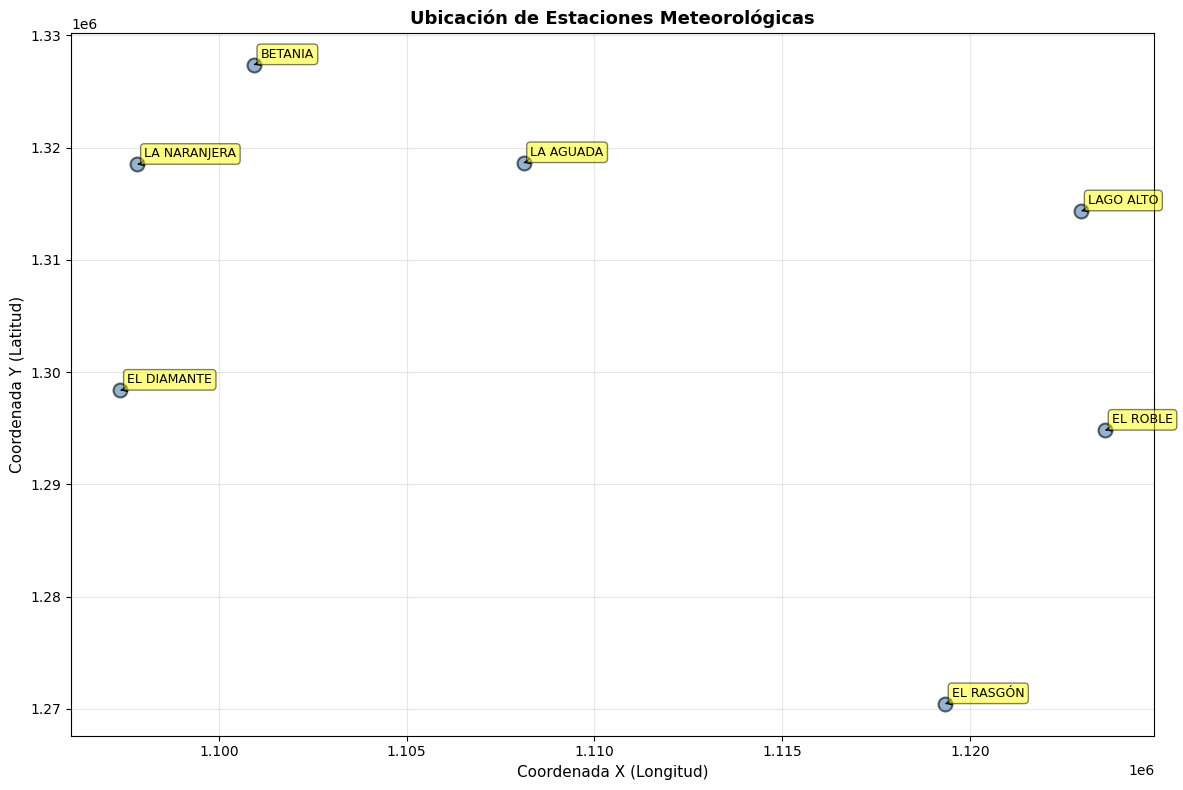

In [37]:
import matplotlib.pyplot as plt

# Obtener datos únicos de estaciones
estaciones_coords = data[['estaci_n', 'coordenada_x', 'coordenada_y']].drop_duplicates()

# Crear figura
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar puntos
ax.scatter(estaciones_coords['coordenada_x'], 
           estaciones_coords['coordenada_y'], 
           s=100, alpha=0.6, c='steelblue', edgecolors='black', linewidth=1.5)

# Añadir etiquetas con nombres de estaciones
for idx, row in estaciones_coords.iterrows():
    ax.annotate(row['estaci_n'], 
                xy=(row['coordenada_x'], row['coordenada_y']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.set_xlabel('Coordenada X (Longitud)', fontsize=11)
ax.set_ylabel('Coordenada Y (Latitud)', fontsize=11)
ax.set_title('Ubicación de Estaciones Meteorológicas', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
data.head()

,estaci_n,tipo,coordenada_x,coordenada_y,date,time,out,hum,speed,dir,bar,rain,rad,index,dir_deg,datetime
0,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,12:00:00,25.3,87.0,0.9,WNW,675.3,0.0,485.0,-999.0,292.5,2021-06-30 12:00:00
1,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,13:00:00,25.2,87.0,0.4,W,674.8,0.0,398.0,-999.0,270.0,2021-06-30 13:00:00
2,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,14:00:00,23.9,95.0,0.0,W,674.3,0.0,165.0,-999.0,270.0,2021-06-30 14:00:00
3,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,15:00:00,24.1,93.0,0.0,W,674.2,0.0,219.0,-999.0,270.0,2021-06-30 15:00:00
4,BETANIA,CLIMATOLOGICA,1100932,1327382,2021-06-30,16:00:00,23.7,92.0,0.0,WSW,674.0,0.0,164.0,-999.0,247.5,2021-06-30 16:00:00


In [39]:
! mkdir ../data/interim

mkdir: cannot create directory ‘../data/interim’: File exists


<Axes: >

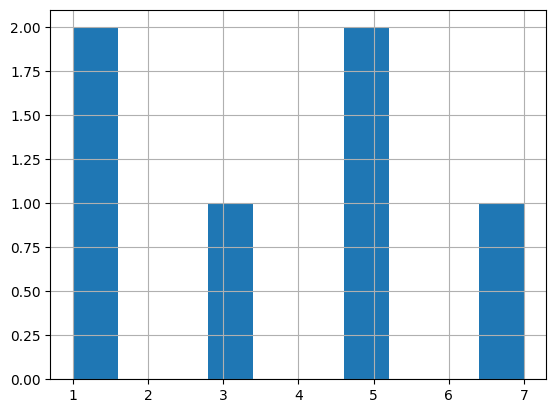

In [49]:
pd.Series([1, 3, 5, 5, 7, 1]).hist()

<Axes: >

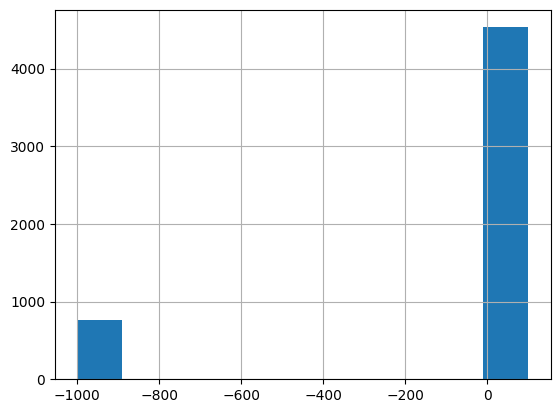

In [63]:
data.loc[:, 'hum'].hist()

<Axes: >

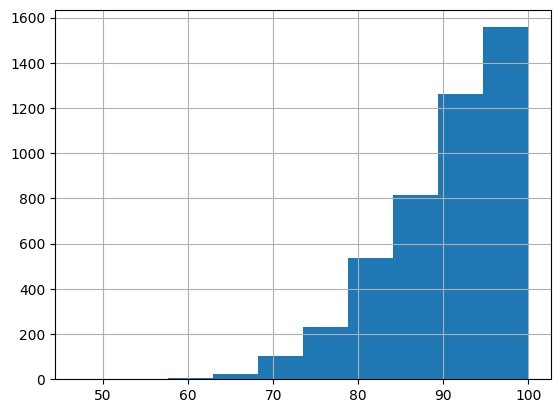

In [ ]:
data.loc[data['hum'] > 0, 'hum'].hist()

In [ ]:
# data.columns
data = data[['estaci_n', 'datetime', 'coordenada_x', 'coordenada_y', 'hum', 'speed', 'bar', 'dir_deg']].copy()
data.to_parquet(
    '../data/interim/data.parquet',
    index=False,
    engine='pyarrow',
    compression='snappy'
    )